In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications
import cv2, os, random
import pathlib

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()

path_for_data = pathlib.Path(current_dir) / 'data' / 'dataset' / 'crop'

print('If correct, Active Directory should read: /Users/delimey/Documents/VisualStudio/aircraft-id')
print(f"Active Directory: {current_dir}")
print(f'Image source is set to {path_for_data}')

# un comment to check source directory contains expected files
# for dirname, _, filenames in os.walk(current_dir):
#     for filename in filenames:
#         print(os.path.join(dirname, filename)),

If correct, Active Directory should read: /Users/delimey/Documents/VisualStudio/aircraft-id
Active Directory: /Users/delimey/Documents/VisualStudio/aircraft-id
Image source is set to /Users/delimey/Documents/VisualStudio/aircraft-id/data/dataset/crop


In [2]:
train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.3,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 30,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_data,
                                             image_size = (128, 128),
                                             validation_split = 0.35,
                                             subset = "validation",
                                             shuffle = True,                                         
                                             batch_size = 30,
                                             seed = 123)

Found 21739 files belonging to 46 classes.
Using 15218 files for training.
Found 21739 files belonging to 46 classes.
Using 7608 files for validation.


In [3]:
validation_batches = tf.data.experimental.cardinality(validation_df)
validation_batches

# take validation batches for test set
test_df = validation_df.take(validation_batches // 5)

# skip validation batches for validation set
validation_df = validation_df.skip(validation_batches // 5)

test_df, validation_df

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [4]:
class_names = train_df.class_names

image_size = (128, 128)
image_shape = image_size + (3,)

preprocess_input = applications.resnet50.preprocess_input

data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))

nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')
base_model.trainable = False

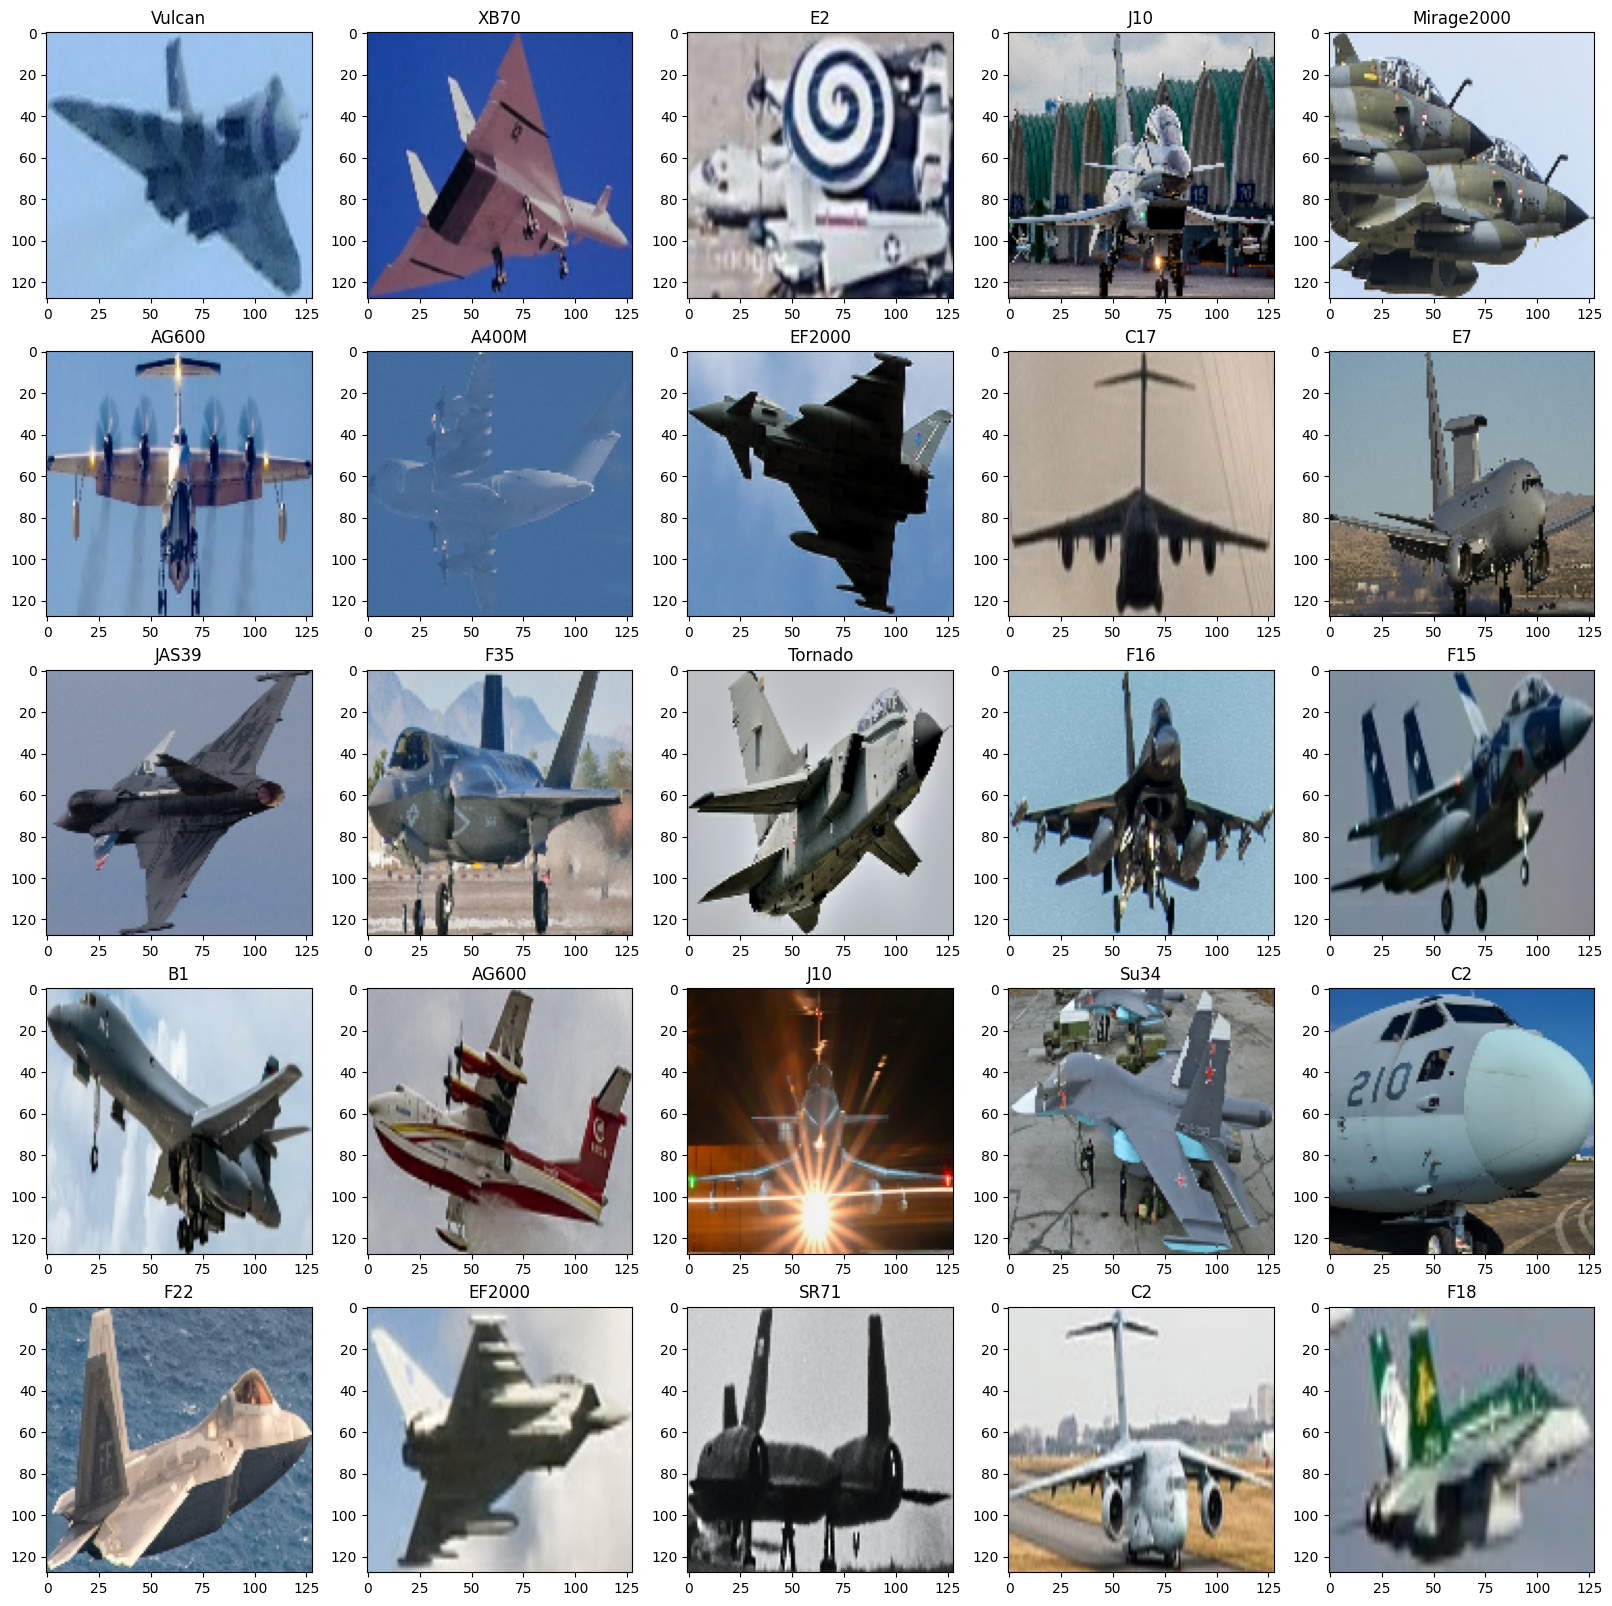

In [5]:
plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [6]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
image_file = f'{current_dir}/model_plot.png'
plot_model(model, to_file = image_file, show_shapes = True)

In [8]:
autotune = tf.data.AUTOTUNE
pf_train = train_df.prefetch(buffer_size = autotune)
pf_test = test_df.prefetch(buffer_size = autotune)
pf_val = validation_df.prefetch(buffer_size = autotune)

In [9]:
from tensorflow.keras import optimizers, losses

# Use the legacy Adam optimizer as recommended
optimizer = optimizers.legacy.Adam(learning_rate=optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=500))

loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:
history = model.fit(pf_train, validation_data = (pf_val), epochs = 1)

508/508 [==============================] - 178s 348ms/step - loss: 2.7421 - accuracy: 0.3253 - val_loss: 2.1941 - val_accuracy: 0.4214


In [11]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
    
optimizer = optimizers.legacy.RMSprop(learning_rate=optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [12]:
ft_epoch = 1
n_epochs =+ ft_epoch
history_fine = model.fit(pf_train, validation_data = (pf_val), epochs = n_epochs, initial_epoch = history.epoch[-1])

508/508 [==============================] - 337s 659ms/step - loss: 1.6804 - accuracy: 0.5560 - val_loss: 0.8716 - val_accuracy: 0.7526


In [13]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

1/1 [==============================] - 1s 709ms/step


In [14]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

[[10 10]
 [38 38]
 [14 35]
 [29 29]
 [20 20]
 [20 20]
 [21 21]
 [ 8  8]
 [ 8  8]
 [29 24]
 [ 0  0]
 [ 6  6]
 [ 3  3]
 [43 44]
 [11  9]
 [ 2 42]
 [25 25]
 [38 38]
 [ 2 12]
 [ 4  4]
 [33 33]
 [ 4 38]
 [ 8  8]
 [41 41]
 [19 19]
 [36 36]
 [28 28]
 [ 7  7]
 [ 0  0]
 [13  0]]


In [15]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

# Get predictions for the batch
predictions = model.predict(image_batch)

# Get predicted classes and their corresponding probabilities
pred_probs = np.max(predictions, axis=1)



show_images = False


if show_images:
    plt.figure(figsize=(10, 20))
    for i in range(num_images):
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_batch[i].astype("uint8"))
        actual_label = class_names[label_batch[i]]
        predicted_label = class_names[pred_labels[i]]
        probability = pred_probs[i] * 100  
        plt.title(f"Predicted: {predicted_label} ({probability:.2f}%), Actual: {actual_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    for i in range(num_images):
        actual_label = class_names[label_batch[i]]
        predicted_label = class_names[pred_labels[i]]
        probability = pred_probs[i] * 100  # Convert to percentage
        print(f"Image {i+1}: Predicted: {predicted_label} ({probability:.2f}%), Actual: {actual_label}")

1/1 [==============================] - 0s 296ms/step


NameError: name 'num_images' is not defined